In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc

# 1. Create a state vector based on the Creutz ladder model:

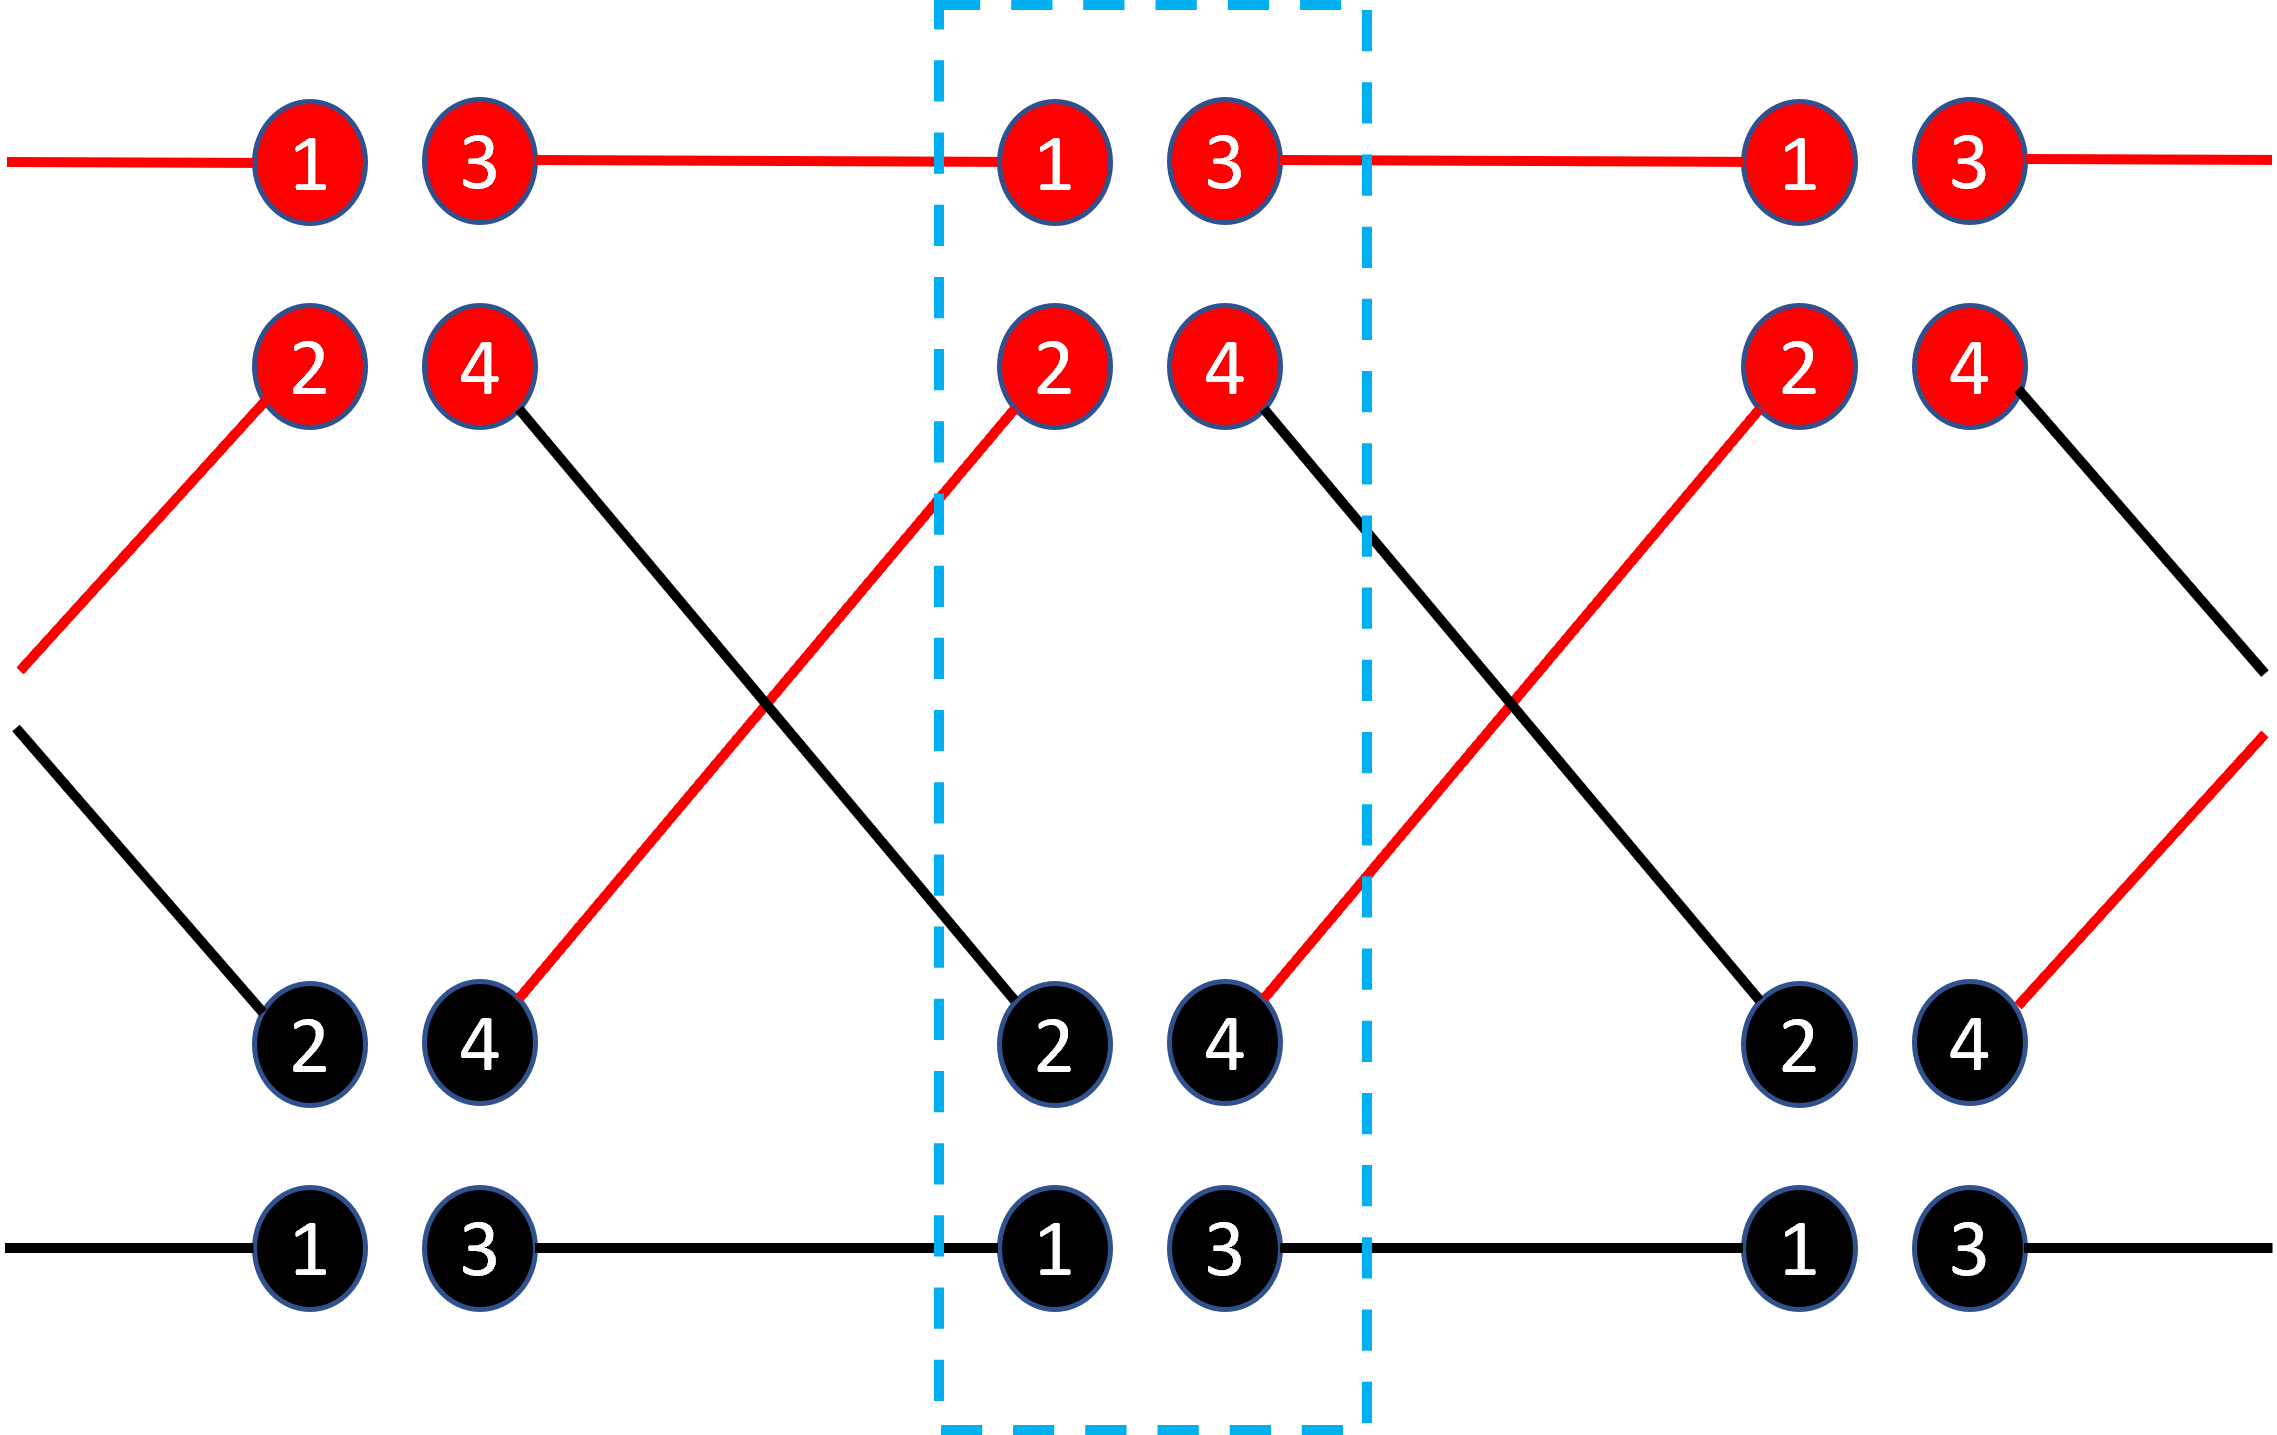

As seen in the above figure, one position has 8 states, including 2 colors and 4 coins. Therefore, to represent $ n $ positions and 8 states, we need a vector of size $ 8n $.

In [2]:
def state(pos,coin,color,N_sites):
  # The initial position in the range from [-N_sites, N_sites] is shifted to [0, 2*N_sites].
  # Create a position vector.
  pos_state = np.zeros(N_sites,dtype=float)
  pos_state[pos+N_sites//2]=1

  # Create a color vector.
  if color == "R":
    color_state = np.array([1,0])
  else:
    color_state = np.array([0,1])

  # Create a coin vector.
  coin_state = np.zeros(4,dtype=float)
  coin_state[coin-1] = 1

  # Calculate the state vector by taking the tensor product of the three vectors: position, color, and coin.
  result_state = np.kron(np.kron(pos_state,color_state),coin_state)
  return result_state

# For convenience in translating from mathematical notation to a computer function.
def braket(pos,coin, N):
  # If the position goes out of the predefined bounds, it will be wrapped around to the opposite end.
  if(pos<-N//2+1):
    pos = N//2
  if (pos>N//2):
    pos = -N//2+1
  return state(pos,int(coin[0]),coin[1],N)

# 2. Create the coin operator:

\begin{equation}
    G_4 = \frac{1}{2} \begin{bmatrix}
    -1 & 1 & 1 & 1 \\
    1 & -1 & 1 & 1 \\
    1 & 1 & -1 & 1 \\
    1 & 1 & 1 & -1
    \end{bmatrix}, \quad C = \rm Id \otimes G_4
\end{equation}

In [3]:
def coin_operator(N_sites):
  # Create the identity matrix for the position.
  Id_pos = np.zeros((N_sites,N_sites),dtype=float)
  for i in range(N_sites):
    Id_pos[i][i] = 1

  # Create the identity matrix for the color.
  Id_color = np.zeros((2,2),dtype=float)
  for i in range(2):
    Id_color[i][i] = 1

  # Create the Grover coin matrix.
  G4 = np.ones((4,4),dtype=float)
  for i in range(4):
    G4[i][i] = -1
  G4 *= 1/2

  # Create the coin operator by taking the tensor product of the identity matrix and the Grover coin matrix.
  final_matrix = np.kron(np.kron(Id_pos, Id_color),G4)
  return final_matrix

# 3. Create the shift operator:


\begin{equation}
    \begin{aligned}
    S & = \sum_{i} \Big( -\left| i-1,3R \right\rangle \left\langle i,1R \right|-\left| i+1,1R \right\rangle \left\langle i,3R \right|-\left| i-1,4B \right\rangle\left\langle i,2R \right|  \\
    & + \left| i+1,2B \right\rangle\left\langle i,4R \right| + \left| i-1,3B \right\rangle \left\langle i,1B \right| + \left| i+1,1B \right\rangle\ \left\langle i,3B \right| \\
    & + \left| i-1,4R \right\rangle\left\langle i,2B \right| - \left| i+1,2R \right\rangle\left\langle i,4B \right|  \Big).
    \end{aligned}
\end{equation}

**Notes:** $\left| i-1, 3R \right\rangle\ $denotes the bra of position \(i-1\) with the red color state (black being $B$), and the coin state 3.

Based on the formula above, we have a function to calculate the shift operator:

In [4]:
def shift_operator(N_sites):
  S = np.zeros((8*N_sites,8*N_sites))
  for i in range(-N_sites//2+1,N_sites//2+1):
    # Công thức của Shift operator
    S += -np.outer(braket(i-1,"3R",N_sites),braket(i,"1R",N_sites)) - np.outer(braket(i+1,"1R",N_sites),braket(i,"3R",N_sites)) - np.outer(braket(i-1,"4B",N_sites),braket(i,"2R",N_sites)) + np.outer(braket(i+1,"2B",N_sites),braket(i,"4R",N_sites)) + np.outer(braket(i-1,"3B",N_sites),braket(i,"1B",N_sites)) + np.outer(braket(i+1,"1B",N_sites),braket(i,"3B",N_sites)) + np.outer(braket(i-1,"4R",N_sites),braket(i,"2B",N_sites)) - np.outer(braket(i+1,"2R",N_sites),braket(i,"4B",N_sites))
  return S

# 4. Bring it all together:
Applying the formula below, we obtain the function state_system.

\begin{equation}
    \left| \psi_T \right\rangle = W^{T} \left| \psi_0 \right\rangle, \quad W = SC
\end{equation}

In [5]:
# Using the formula above, we get
def state_system(N_sites,initial_pos,initial_coin,initial_color ,time):
  WT = W = shift_operator(N_sites)@coin_operator(N_sites)
  for i in range(time-1):
    WT = WT @ W
  return WT @ state(initial_pos,initial_coin,initial_color,N_sites)

# Modify the state_system function so that it can create an animation that evolves over time.
def probability_animation(N_sites,initial_pos,initial_coin,initial_color ,time):
  probabilities = []
  WT = W = shift_operator(N_sites) @ coin_operator(N_sites)
  probabilities.append((WT @ state(initial_pos,initial_coin,initial_color,N_sites))**2)
  for i in range(1,time):
    WT = WT @ W
    probabilities.append((WT @ state(initial_pos,initial_coin,initial_color,N_sites))**2)
  return probabilities

  Let's create an animation.

In [6]:
TIME = 10 # Time T
RANGE = 9 # Range of the particle's position: [-RANGE//2,RANGE//2]

# Random the state
coin = np.random.randint(1,5)
color = np.random.randint(0,2)
if color==0:
  color_text="R"
else: color_text="B"

# Return a 2D array with dimensions T x 8*RANGE
prob = probability_animation(RANGE,0,coin,color_text,TIME)

# Process the prob to determine the particle's position and color, ignoring the coin state.
z_axis = [] # z_axis has dimensions T x 2*RANGE
temp = []
for j in range(TIME):
  for i in range(8*RANGE):
    if((i+1)%4==0):
      temp.append(np.sum(prob[j][i-3:i+1]))
  z_axis.append(temp)
  temp = []

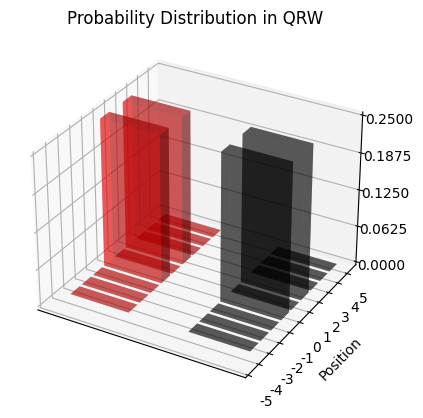

In [7]:
# This line to run video in colab.
rc('animation', html='jshtml')

x = []
y = []

# Set up the x and y values for the bars.
for i in range(RANGE):
  x.append(0)
  x.append(0.8)
for i in range(-RANGE//2+1,RANGE//2+1):
  y.append(i)
  y.append(i)

# The base of bar graph in z-axis is 0.
z = np.zeros(RANGE*2)

# Set up the figure and axis.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create the bar graph.
# Width and depth of the bars.
dx = 0.4
dy = 0.8
# Height of the bars (probabilities).
dz = np.array(z_axis)

# Function to run animation.
def animate(i):
  ax.clear()
  for j in range(2*RANGE):
    # Black is odd index and Red is even index.
    if j % 2 == 0:
      ax.bar3d(x[j], y[j], z[j], dx, dy, dz[i][j],alpha=0.4,color='r')
    else:
      ax.bar3d(x[j], y[j], z[j], dx, dy, dz[i][j],alpha=0.4,color='k')


  # Adjust the ticks on the y-axis to be centered.
  labels = []
  axis = []
  for i in range(-RANGE//2,RANGE//2+2):
    axis.append(i-0.5)
    labels.append(i)

  # Set ticks.
  ax.set_zticks(np.linspace(0,0.25,5,dtype=float))
  plt.yticks(axis,labels)
  plt.xticks([])

  ax.set_ylabel('Position')
  plt.title("Probability Distribution in QRW")
  return ax


# Run animation.
anim = animation.FuncAnimation(fig, animate, frames=TIME, interval=500)
anim